In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colab = True
name = "0086-GAN-0051"

if not colab: 
  train_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\train'
  validation_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\validation'
  test_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\test'

else:
  train_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/train'
  validation_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/validation'
  test_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/test'
  mini_test_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/mini_test'

batch_size = 8
img_height = 1024 #1792
img_width = 768 #1280
img_gen = ImageDataGenerator()

train_gen = img_gen.flow_from_directory(train_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

validation_gen = img_gen.flow_from_directory(validation_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

test_gen = img_gen.flow_from_directory(test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

mini_test_gen = img_gen.flow_from_directory(mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = 1, color_mode = "rgb", class_mode = "input", shuffle = False)

Found 1574 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [3]:
import tensorflow
!nvidia-smi
#12.7 GB RAM
# 15.0 GB GPU
!python ‐‐version
!pip show keras
print(tensorflow.__version__)

Wed Feb 22 21:05:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
import tensorflow as tf

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def to_grayscale_then_rgb(image):
    image = rgb_to_grayscale(image)
    image = grayscale_to_rgb(image)
    return image

def preprocess(data):
    i = 0
    for imgs in data:
        img, label = imgs
        yield rgb2gray(img) / 255, label/ 255
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [5]:
# example of defining a composite model for training the generator model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(gray_image_shape, RGB_image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 123)
	# source image input
	in_src_image = Input(shape=gray_image_shape)
	# target image input
	in_target_image = Input(shape=RGB_image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 1)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 2)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 5)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 256)
	e5 = define_encoder_block(e4, 256)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 256)
	d4 = decoder_block(d3, e4, 256, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('sigmoid')(g)
	# define model
	model = Model(in_image, out_image, name="generator" )
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, gray_image_shape, RGB_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_gray = Input(shape=gray_image_shape, name = "in_gray")
	in_RGB = Input(shape=RGB_image_shape, name = "in_RGB")
	print(in_gray.shape, in_RGB.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_gray)
	
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_gray, gen_out])

	# src image as input, generated image and classification output
	model = Model(in_gray, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', SSIMLoss], optimizer=opt, loss_weights=[1,100])
	return model

# define image shape
gray_image_shape=(img_height,img_width,1)
RGB_image_shape=(img_height,img_width,3)
# define the models
d_model = define_discriminator(gray_image_shape, RGB_image_shape)
g_model = define_generator(gray_image_shape)
#d_model.summary()
#g_model.summary()
# define the composite model
gan_model = define_gan(g_model, d_model, gray_image_shape, RGB_image_shape)
# summarize the model
gan_model.summary()
# plot the model
#plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

(None, 1024, 768, 1) (None, 1024, 768, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_gray (InputLayer)           [(None, 1024, 768,   0           []                               
                                1)]                                                               
                                                                                                  
 generator (Functional)         (None, 1024, 768, 3  35547779    ['in_gray[0][0]']                
                                )                                                                 
                                                                                                  
 model (Functional)             (None, 64, 48, 1)    6966209     ['in_gray[0][0]',                
                                                  

In [6]:
n_steps = 6000
n_validation = 20
index = 0
history = {"d_loss1":[0.0]*(n_steps//n_validation),
	           "d_loss2":[0.0]*(n_steps//n_validation),
	           "g_loss":[0.0]*(n_steps//n_validation),
						 "val_d_loss1":[0.0]*(n_steps//n_validation),
						 "val_d_loss2":[0.0]*(n_steps//n_validation),
						 "val_g_loss":[0.0]*(n_steps//n_validation)	}

In [7]:
import numpy as np
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	#trainA, trainB = dataset
	trainA, trainB = next(dataset)
	# choose random instances
	#ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA, trainB
	# generate 'real' class labels (1)
	y = np.ones((trainA.shape[0], patch_shape[0], patch_shape[1], 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape[0], patch_shape[1], 1))
	return X, y

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, validation_dataset, n_steps, n_validation, n_batch, n_patch, index):
	# unpack dataset
	#n_patch = (112,80)
	#trainA, trainB = dataset
	# calculate the number of batches per training epoch
	#bat_per_epo = int(len(trainA) / n_batch)
	bat_per_epo = 2000
	# calculate the number of training iterations
	
	print(index)
	history_d_loss1 = 0
	history_d_loss2 = 0
	history_g_loss = 0 

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples


		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		history_d_loss1 = history_d_loss1 + d_loss1
		history_d_loss2 = history_d_loss2 + d_loss2
		history_g_loss = history_g_loss + g_loss 

		# summarize performance
	
		
		if (i+1) % n_validation == 0  and i != 0:
			history["d_loss1"][index] = (history_d_loss1/n_validation)
			history["d_loss2"][index] = (history_d_loss2/n_validation)
			history["g_loss"][index] = (history_g_loss/n_validation)
	 
			history_d_loss1 = 0
			history_d_loss2 = 0
			history_g_loss = 0

			# select a batch of real samples
			[X_realA, X_realB], y_real = generate_real_samples(validation_dataset, n_batch, n_patch)
			# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
			# update discriminator for real samples

			d_loss1 = d_model.evaluate([X_realA, X_realB], y_real)
			# update discriminator for generated samples
			d_loss2 = d_model.evaluate([X_realA, X_fakeB], y_fake)
			# update the generator
			g_loss, _, _ = gan_model.evaluate(X_realA, [y_real, X_realB])
			# summarize performance

			history["val_d_loss1"][index] = (d_loss1)
			history["val_d_loss2"][index] = (d_loss2)
			history["val_g_loss"][index] = (g_loss)
	 
			index = index + 1
			#print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			print(index)

In [8]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 0)

0
1/1 [==============================] - 1s 1s/step - loss: 54.5762 - model_loss: 0.7299 - generator_loss: 0.5385
1
1/1 [==============================] - 1s 684ms/step - loss: 42.4676 - model_loss: 0.6623 - generator_loss: 0.4181
2
1/1 [==============================] - 1s 662ms/step - loss: 37.5715 - model_loss: 0.2910 - generator_loss: 0.3728
3
1/1 [==============================] - 1s 667ms/step - loss: 28.3066 - model_loss: 0.3010 - generator_loss: 0.2801
4
1/1 [==============================] - 1s 695ms/step - loss: 23.8044 - model_loss: 0.4382 - generator_loss: 0.2337
5
1/1 [==============================] - 1s 662ms/step - loss: 26.5236 - model_loss: 0.6679 - generator_loss: 0.2586
6
1/1 [==============================] - 1s 665ms/step - loss: 20.8316 - model_loss: 1.0823 - generator_loss: 0.1975
7
1/1 [==============================] - 1s 667ms/step - loss: 22.7631 - model_loss: 1.4589 - generator_loss: 0.2130
8
1/1 [==============================] - 1s 669ms/step - loss: 24.4

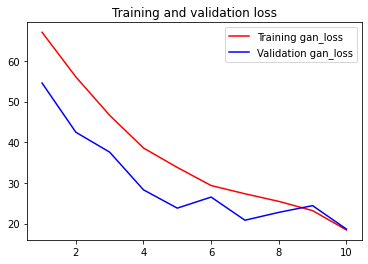

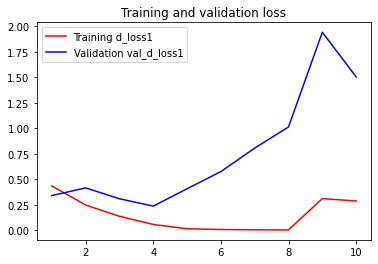

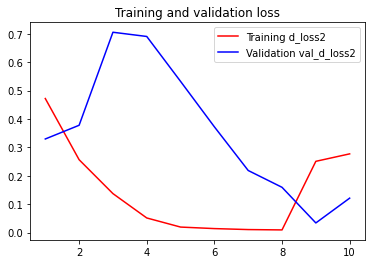

In [9]:
index = 10
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
name = "0086-GAN-0046-200"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

In [13]:
from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 27ms/step


In [14]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 10)

10
1/1 [==============================] - 1s 654ms/step - loss: 20.5953 - model_loss: 1.5695 - generator_loss: 0.1903
11
1/1 [==============================] - 1s 707ms/step - loss: 19.3870 - model_loss: 1.5365 - generator_loss: 0.1785
12
1/1 [==============================] - 1s 663ms/step - loss: 16.4223 - model_loss: 2.1149 - generator_loss: 0.1431
13
1/1 [==============================] - 1s 659ms/step - loss: 14.3085 - model_loss: 0.1017 - generator_loss: 0.1421
14
1/1 [==============================] - 1s 670ms/step - loss: 15.5034 - model_loss: 0.5804 - generator_loss: 0.1492
15
1/1 [==============================] - 1s 663ms/step - loss: 19.7094 - model_loss: 9.3303 - generator_loss: 0.1038
16
1/1 [==============================] - 1s 667ms/step - loss: 12.0909 - model_loss: 0.9414 - generator_loss: 0.1115
17
1/1 [==============================] - 1s 658ms/step - loss: 19.1759 - model_loss: 2.3185 - generator_loss: 0.1686
18
1/1 [==============================] - 1s 663ms/step 

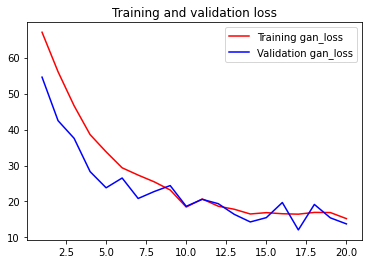

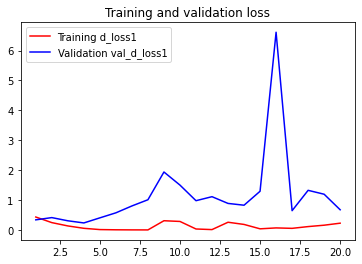

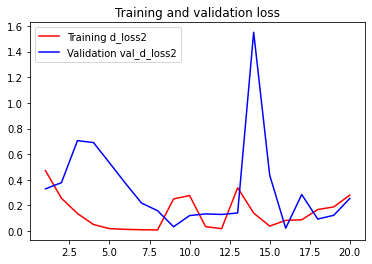

In [15]:
index = 20
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
name = "0086-GAN-0046-400"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 49ms/step


In [18]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 20)

20
1/1 [==============================] - 2s 2s/step - loss: 15.6337 - model_loss: 5.1135 - generator_loss: 0.1052
21
1/1 [==============================] - 1s 673ms/step - loss: 18.1173 - model_loss: 2.4643 - generator_loss: 0.1565
22
1/1 [==============================] - 1s 685ms/step - loss: 12.1896 - model_loss: 0.4743 - generator_loss: 0.1172
23
1/1 [==============================] - 1s 729ms/step - loss: 11.9233 - model_loss: 1.3984 - generator_loss: 0.1052
24
1/1 [==============================] - 1s 661ms/step - loss: 10.3064 - model_loss: 1.5193 - generator_loss: 0.0879
25
1/1 [==============================] - 1s 669ms/step - loss: 17.4479 - model_loss: 7.1696 - generator_loss: 0.1028
26
1/1 [==============================] - 1s 677ms/step - loss: 11.7921 - model_loss: 2.2758 - generator_loss: 0.0952
27
1/1 [==============================] - 1s 669ms/step - loss: 17.3414 - model_loss: 2.9972 - generator_loss: 0.1434
28
1/1 [==============================] - 1s 668ms/step - l

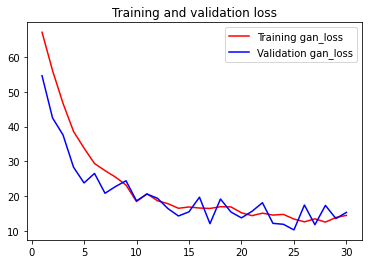

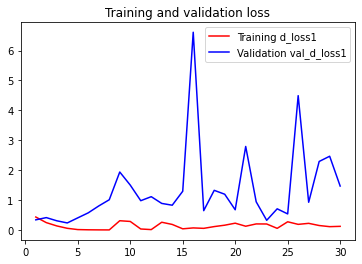

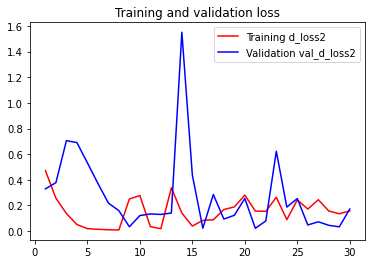

In [19]:
index = 30
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
name = "0086-GAN-0046-600"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 39ms/step


In [21]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 30)

30
1/1 [==============================] - 1s 660ms/step - loss: 16.3880 - model_loss: 4.0952 - generator_loss: 0.1229
31
1/1 [==============================] - 1s 693ms/step - loss: 13.5145 - model_loss: 2.8106 - generator_loss: 0.1070
32
1/1 [==============================] - 1s 669ms/step - loss: 13.3168 - model_loss: 1.2575 - generator_loss: 0.1206
33
1/1 [==============================] - 1s 675ms/step - loss: 10.4370 - model_loss: 1.3835 - generator_loss: 0.0905
34
1/1 [==============================] - 1s 723ms/step - loss: 12.3739 - model_loss: 1.8045 - generator_loss: 0.1057
35
1/1 [==============================] - 1s 668ms/step - loss: 17.5929 - model_loss: 4.8692 - generator_loss: 0.1272
36
1/1 [==============================] - 1s 700ms/step - loss: 17.0286 - model_loss: 4.7692 - generator_loss: 0.1226
37
1/1 [==============================] - 1s 680ms/step - loss: 8.4037 - model_loss: 1.6235 - generator_loss: 0.0678
38
1/1 [==============================] - 1s 671ms/step -

In [22]:
name = "0086-GAN-0051-800"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 24ms/step


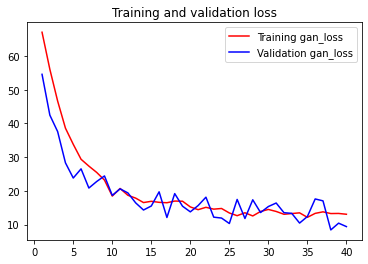

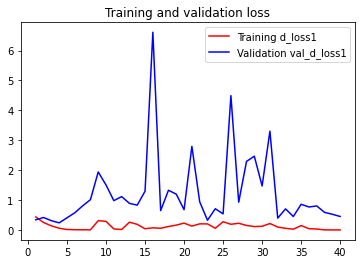

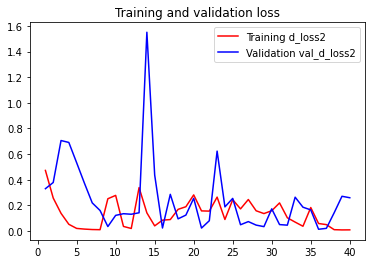

In [23]:
index = 40
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 40)

40
1/1 [==============================] - 1s 668ms/step - loss: 8.4893 - model_loss: 0.9758 - generator_loss: 0.0751
41
1/1 [==============================] - 1s 662ms/step - loss: 6.6903 - model_loss: 1.5001 - generator_loss: 0.0519
42
1/1 [==============================] - 1s 695ms/step - loss: 18.1965 - model_loss: 1.3990 - generator_loss: 0.1680
43
1/1 [==============================] - 1s 664ms/step - loss: 9.8300 - model_loss: 0.5901 - generator_loss: 0.0924
44
1/1 [==============================] - 1s 664ms/step - loss: 9.5573 - model_loss: 0.6460 - generator_loss: 0.0891
45
1/1 [==============================] - 1s 672ms/step - loss: 13.5337 - model_loss: 0.9547 - generator_loss: 0.1258
46
1/1 [==============================] - 1s 684ms/step - loss: 10.5063 - model_loss: 0.6842 - generator_loss: 0.0982
47
1/1 [==============================] - 1s 695ms/step - loss: 8.5251 - model_loss: 1.9073 - generator_loss: 0.0662
48
1/1 [==============================] - 1s 670ms/step - los

In [25]:
name = "0086-GAN-0051-1000"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 23ms/step


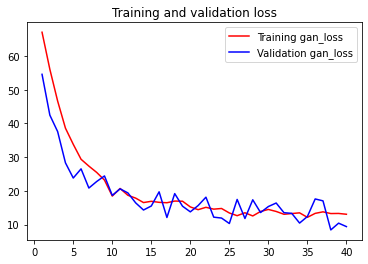

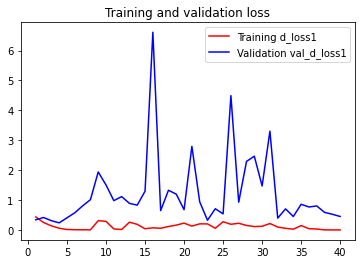

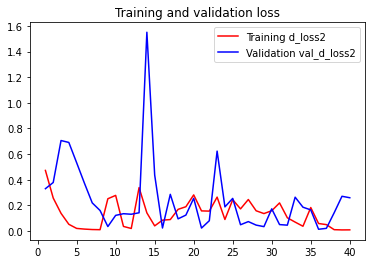

In [26]:
index = 40
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

50
1/1 [==============================] - 1s 661ms/step - loss: 9.5635 - model_loss: 1.0878 - generator_loss: 0.0848
51
1/1 [==============================] - 1s 662ms/step - loss: 8.3758 - model_loss: 1.3173 - generator_loss: 0.0706
52
1/1 [==============================] - 1s 663ms/step - loss: 9.9105 - model_loss: 2.0915 - generator_loss: 0.0782
53
1/1 [==============================] - 1s 675ms/step - loss: 10.9598 - model_loss: 1.9783 - generator_loss: 0.0898
54
1/1 [==============================] - 1s 662ms/step - loss: 11.1873 - model_loss: 1.4242 - generator_loss: 0.0976
55
1/1 [==============================] - 1s 670ms/step - loss: 10.9683 - model_loss: 0.7940 - generator_loss: 0.1017
56
1/1 [==============================] - 1s 707ms/step - loss: 10.5805 - model_loss: 1.0701 - generator_loss: 0.0951
57
1/1 [==============================] - 1s 668ms/step - loss: 8.8782 - model_loss: 1.1612 - generator_loss: 0.0772
58
1/1 [==============================] - 1s 668ms/step - lo

1/1 [==============================] - 0s 28ms/step


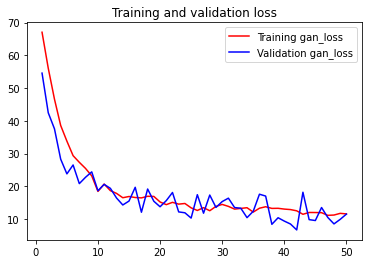

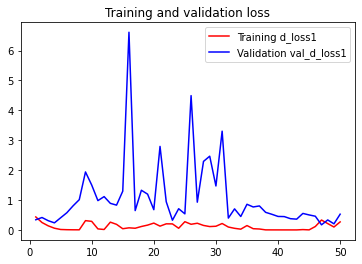

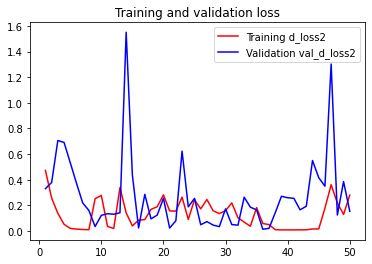

In [27]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 200, n_validation = 20, n_patch = (64, 48), index = 50)

name = "0086-GAN-0051-1200"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0086/' + name + '-' + str(i) + ".jpg", p[0])
  #


index = 50
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()